# <font color=black> Analysis - ICA vs iCAP in the spinal cord </font>
<hr style="border:1px solid black">

**The goal of this analysis is to investigate the reproducibility of spinal networks extracted using different methods and datasets.**

**METHODS CONSIDERED:**
- Independent Component Analysis – called `ica` in this script
- Innovation-driven CoActivation Pattern analysis – called `icap` in this script

**DATASETS:**
- A dataset covering C1 to C8 spinal levels, with a resolution of 1.6x1.6x4mm<sup>3</sup>  and a TR of 1.55s – called `mtl` in this script
- A dataset covering C5 to C8 spinal levels, with a resolution of 1x1x3mm<sup>3</sup> and a TR of 2.5s – called `gva` in this script

**ANALYSES:**
- _**Qualitative:**_ matching & visualization of one or two set(s) of components
- _**Quantitative:**_
    * Analysis of spatial similarity (for a single K, or across multiple Ks)
    * Distribution across axial subdvisions (D,V,L,R) for different Ks

In [32]:
import sys,json,glob
import numpy as np
import pandas as pd
sys.path.append('/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/hc_project_analyses/code/')

import sc_utilities as utils


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initialization

### Load configuration file 

In [15]:
# Load the config files with all informations (i.e., all datasets, methods, etc.)
with open('../config/config_spine_only_CL.json') as config_file:
    config = json.load(config_file)

# Figure 1  – tSNR

In [78]:
Files_func_sc={}; Files_func_mask={};tSNR_files={};tSNR_means={}
# Select datas
for dataset in ["mtl","gva"]:
    Files_func_sc[dataset]=[]; Files_func_mask[dataset]=[];
    for sbj_nb in range(len(config["list_subjects"][dataset])):
        subject_name=config["list_subjects"][dataset][sbj_nb]
        if dataset=="mtl":
            if subject_name[0] =="A" :
                Files_func_sc[dataset].append(glob.glob("/cerebro/cerebro1/dataset/stratals/derivatives/preprocessing/sub-" + subject_name + "/func/1_STC/spinalcord/" + "*stc_sc.nii.gz")[0])
                Files_func_mask[dataset].append(glob.glob("/cerebro/cerebro1/dataset/stratals/derivatives/preprocessing/sub-" + subject_name + "/func/4_Segmentation/spinalcord/*mean_seg.nii.gz")[0])
            else:
                Files_func_sc[dataset].append(glob.glob("/cerebro/cerebro1/dataset/bmpd/derivatives/spinalcord_processing/sub-" + subject_name + "/func/1_STC/spinalcord/" + "*stc_sc.nii.gz")[0])
                Files_func_mask[dataset].append(glob.glob("/cerebro/cerebro1/dataset/bmpd/derivatives/spinalcord_processing/sub-" + subject_name + "/func/4_Segmentation/spinalcord/*mean_seg.nii.gz")[0])

        elif dataset=="gva":
            Files_func_sc[dataset].append(glob.glob("/cerebro/cerebro1/dataset/caroline/2022_SPiCiCAP_NK_CL/SPiCiCAP_Dataset_Code/Data/sub-"+subject_name+ "/func/mfmri.nii.gz")[0])
            Files_func_mask[dataset].append(glob.glob("/cerebro/cerebro1/dataset/caroline/2022_SPiCiCAP_NK_CL/CL_analyses/preprocessing/sub-"+subject_name+ "/func/4_Segmentation/spinalcord/*mean_seg.nii.gz")[0])
    tSNR_files[dataset],tSNR_means[dataset]=utils.tSNR(config,Files_func_sc[dataset],dataset,mask_files=Files_func_mask[dataset],outputdir=numpy.repeat(config["main_dir"]+config["tSNR_dir"] + "/indiv_maps/" + dataset +"/",len(config["list_subjects"][dataset])), redo=False)
    
dataframe=pd.concat((pd.DataFrame({"subject":config["list_subjects"]["mtl"],"dataset":np.repeat("mtl",len(config["list_subjects"]["mtl"])),"tsnr":tSNR_means["mtl"]}),pd.DataFrame({"subject":config["list_subjects"]["gva"],"dataset":np.repeat("gva",len(config["list_subjects"]["gva"])),"tsnr":tSNR_means["gva"]})),0)
dataframe.to_csv(config["main_dir"]+config["tSNR_dir"] + "/indiv_maps/tsnr_dataframe.csv")

<Figure size 432x288 with 0 Axes>

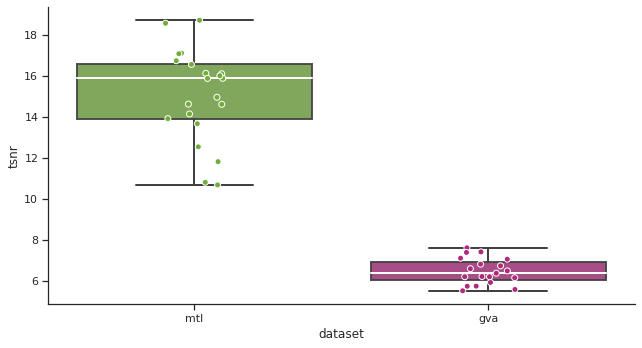

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks",  font='sans-serif')
fig = plt.figure()

colors=["#72ac3bff","#b0297dff"]
sns.set(style="ticks",  font='sans-serif')
g=sns.catplot(y="tsnr",x="dataset",data=dataframe, kind="box", legend=True, legend_out=True,
             linewidth=2,medianprops=dict(color="white"),palette=colors, 
              boxprops=dict(alpha=.9),fliersize=0, aspect=1) #fliersize=0)
g.fig.set_size_inches(10,5)

sns.stripplot(x="dataset", y="tsnr",data=dataframe,
             size=6, palette=colors, linewidth=1,edgecolor='white',dodge=True)



# Figure 2  – FD

In [132]:
Files_moco_params={};meanFD={}
# Select datas
for dataset in ["mtl","gva"]:
    Files_moco_params[dataset]=[]; meanFD[dataset]=[]
    for sbj_nb in range(len(config["list_subjects"][dataset])):
        subject_name=config["list_subjects"][dataset][sbj_nb]
        if dataset=="mtl":
            if subject_name[0] =="A" :
                Files_moco_params[dataset].append(glob.glob("/cerebro/cerebro1/dataset/stratals/derivatives/preprocessing/sub-" + subject_name + "/func/3_MOCO/spinalcord/moco_params.txt")[0])
                
            else:
                Files_moco_params[dataset].append(glob.glob("/cerebro/cerebro1/dataset/bmpd/derivatives/spinalcord_processing/sub-" + subject_name + "/func/3_MOCO/spinalcord/moco_params.txt")[0])
                
        elif dataset=="gva":
            Files_moco_params[dataset].append(glob.glob("/cerebro/cerebro1/dataset/caroline/2022_SPiCiCAP_NK_CL/CL_analyses/preprocessing/sub-"+subject_name+ "/func/3_MOCO/spinalcord/moco_params.txt")[0])
        
        
        params_data=pd.read_csv(Files_moco_params[dataset][sbj_nb], ',', header=None)
        diff_X=np.abs(np.diff(params_data[0]))
        diff_Y=np.abs(np.diff(params_data[1]))
        meanFD[dataset].append([np.mean(diff_X),np.mean(diff_Y),np.mean([np.mean(diff_X),np.mean(diff_Y)])])


#dataframe=pd.concat((pd.DataFrame({"subject":config["list_subjects"]["mtl"],"dataset":np.repeat("mtl",len(config["list_subjects"]["mtl"])),"tsnr":tSNR_means["mtl"]}),pd.DataFrame({"subject":config["list_subjects"]["gva"],"dataset":np.repeat("gva",len(config["list_subjects"]["gva"])),"tsnr":tSNR_means["gva"]})),0)
#dataframe.to_csv(config["main_dir"]+config["tSNR_dir"] + "/indiv_maps/tsnr_dataframe.csv")

In [ ]:
pd.DataFrame(pd.concat(meanFD["mtl"],columns=["FD_X","FD_Y","FD_mean"])

In [136]:
pd.concat(pd.concat((pd.DataFrame(meanFD["mtl"],columns=["FD_X","FD_Y","FD_mean"]),pd.DataFrame(meanFD["gva"],columns=["FD_X","FD_Y","FD_mean"]))))

,FD_X,FD_Y,FD_mean
0,0.031571,0.128974,0.080272
1,0.032766,0.198539,0.115652
2,0.073544,0.148559,0.111051
3,0.070286,0.204475,0.137381
4,0.041845,0.244136,0.142990
5,0.024171,0.101452,0.062812
6,0.079373,0.093352,0.086363
7,0.036956,0.137494,0.087225
8,0.085361,0.198646,0.142003
9,0.069830,0.122689,0.096259


## `mtl` dataset
### Qualitative evaluation

In [4]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis
params_qual_mtl_robustness_1 = {'k':36, 'dataset':'mtl', 'analysis':'ica'}
params_qual_mtl_robustness_2 = {'k':36, 'dataset':'mtl', 'analysis':'ica'}
config["templates"]["spinalcord"]= "/templates/PAM50/template/T2w_group_mean.nii.gz",
plotting_mtl = Plotting(config,'spinalcord',params1=params_qual_mtl_robustness_2,params2=params_qual_mtl_robustness_1)


/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//ICA/results_spine_only/mtl/spinalcord//K_36/comp_zscored/*4D_z*
/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//ICA/results_spine_only/mtl/spinalcord//K_36/comp_zscored/*4D_z*


The plotting will be display in flip orientation (Right > left)
COMPUTING SIMILARITY WITH METHOD: Dice
...Compute similarity between pairs of components
...Ordering components based on maximum weight matching
DONE!


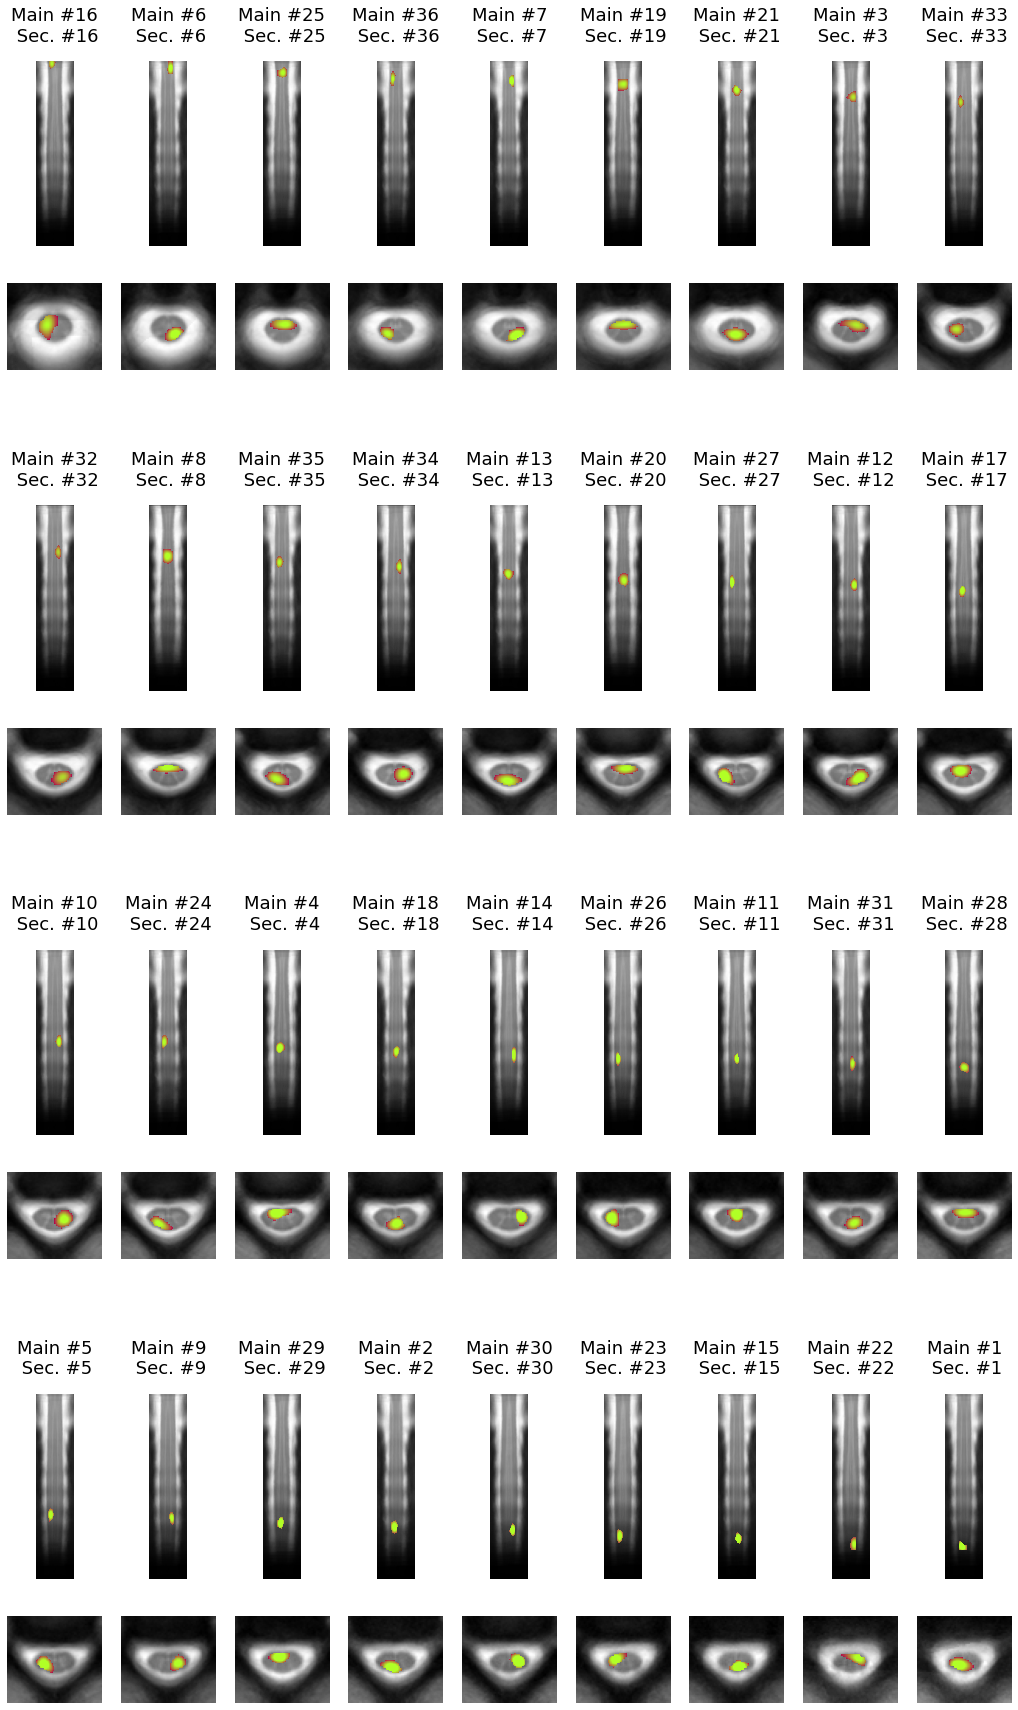

In [5]:
config["templates"]["spinalcord"]="/templates/PAM50/template/T2w_mtl_group_mean_resampled.nii.gz"
plotting_mtl.sc_plot(show_spinal_levels=False, k_per_line=9, lthresh=3, uthresh=6, save_results=False, similarity_method='Dice')

The plotting will be display in flip orientation (Right > left)
COMPUTING SIMILARITY WITH METHOD: Dice
...Compute similarity between pairs of components
...Ordering components based on maximum weight matching
DONE!


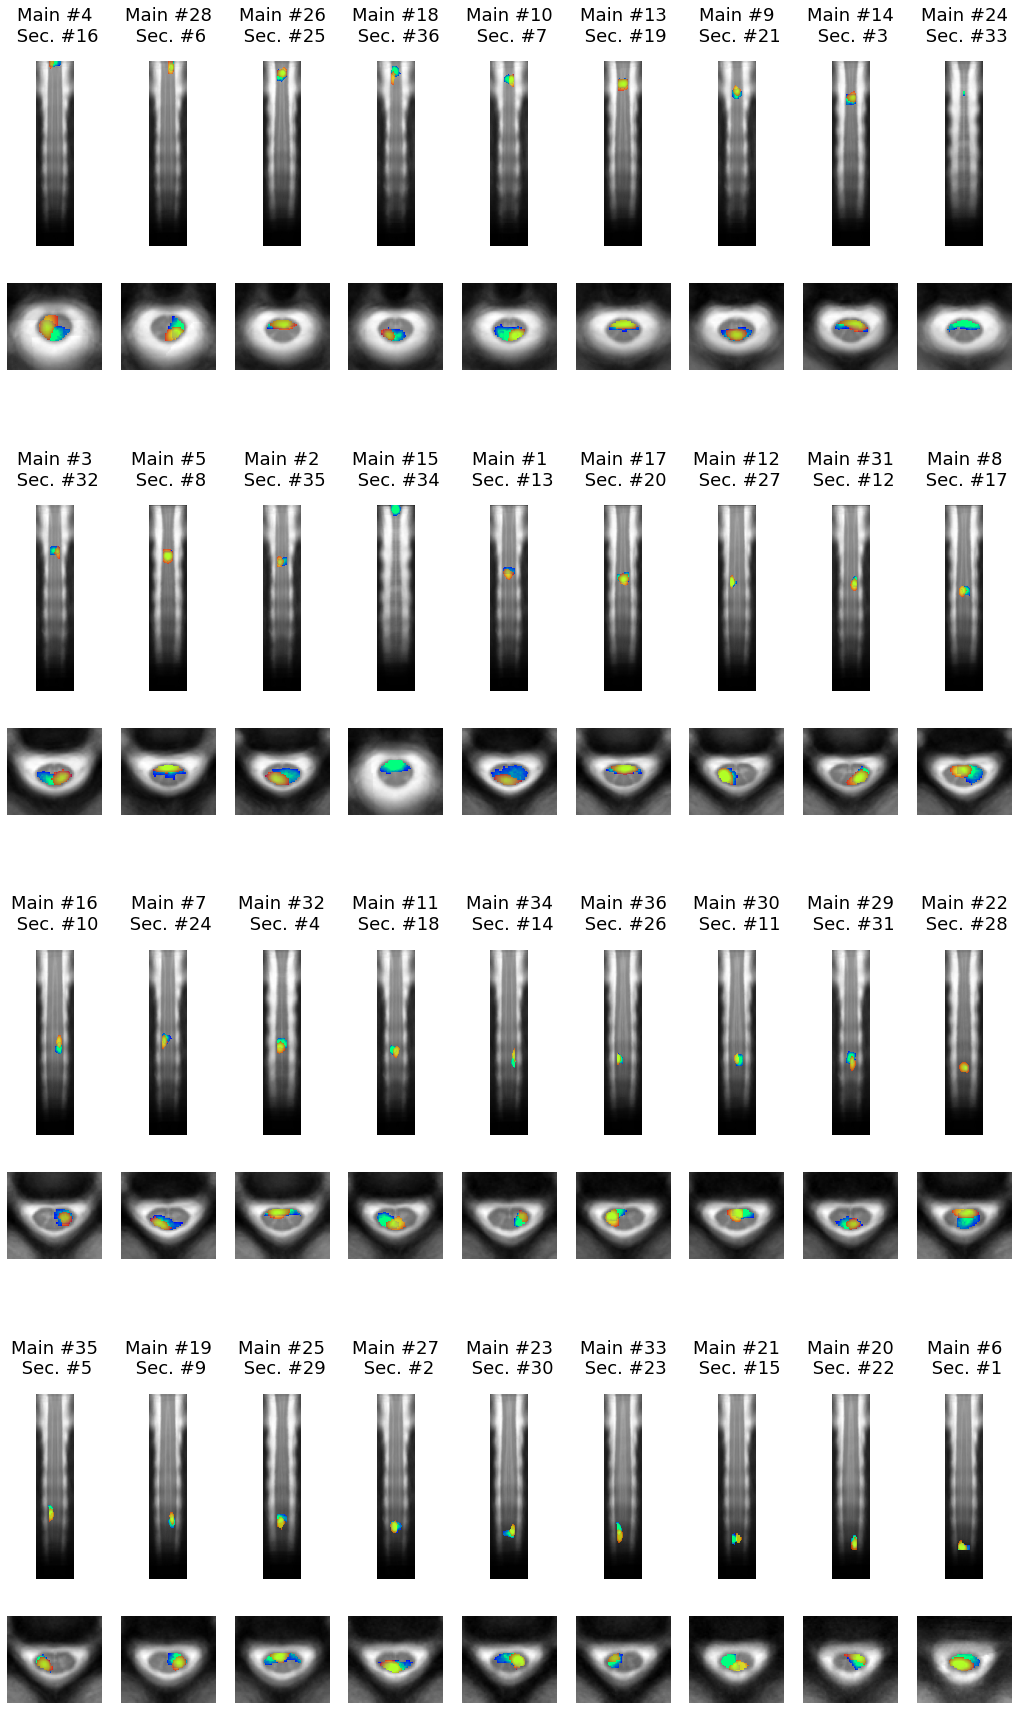

In [10]:
config["templates"]["spinalcord"]="/templates/PAM50/template/T2w_mtl_group_mean_resampled.nii.gz"
plotting_mtl.sc_plot(show_spinal_levels=False, k_per_line=9, lthresh=, uthresh=6, save_results=False, similarity_method='Dice')

The plotting will be display in flip orientation (Right > left)
COMPUTING SIMILARITY WITH METHOD: Dice
...Compute similarity between pairs of components
...Ordering components based on maximum weight matching
DONE!


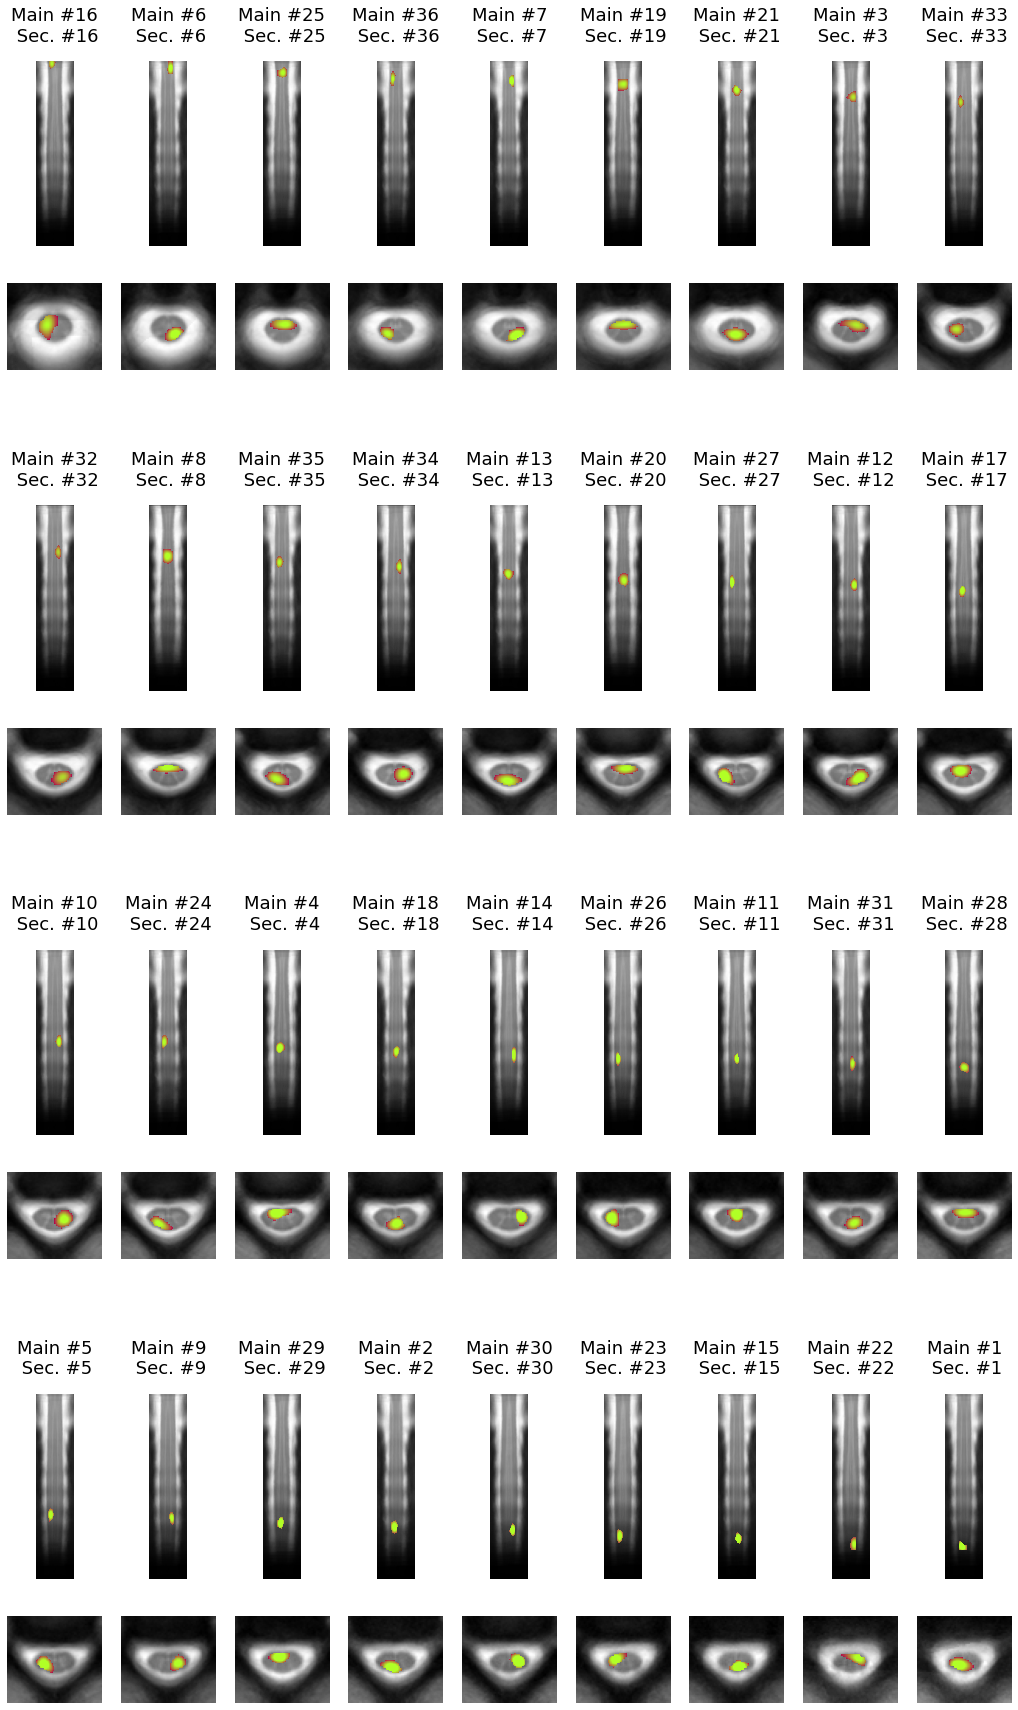

In [8]:
config["templates"]["spinalcord"]="/templates/PAM50/template/T2w_mtl_group_mean_resampled.nii.gz"
plotting_mtl.sc_plot(show_spinal_levels=False, k_per_line=9, lthresh=3, uthresh=6, save_results=False, similarity_method='Dice')

_Note: the component numbers refer to the ones of the original datasets (i.e., before any type of reordering)_

### Quantitative evaluation

METHOD 1: Comparing two sets of components at specific K values 
mtl_ica at K = 36 vs mtl_icap at K = 36 

The mean similarity is 0.54


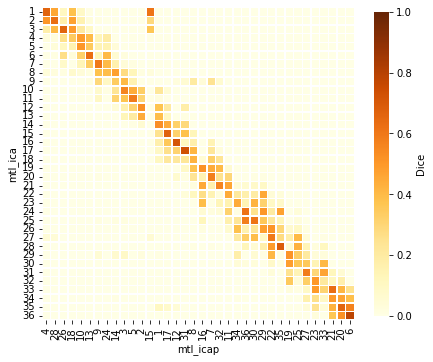

In [48]:
# Similarity has been computed using 'Dice', but 'Cosine' or 'Euclidean distance' could be used instad
params_quant_mtl_robustness_1 = {'k_range':range(36,37), 'dataset':'mtl', 'analysis':'ica'}
params_quant_mtl_robustness_2 = {'k_range':range(36,37), 'dataset':'mtl', 'analysis':'icap'}
spine_analysis_mtl = SpineOnlyAnalysis(config,params1=params_quant_mtl_robustness_1 ,params2=params_quant_mtl_robustness_2)
spine_analysis_mtl.spatial_similarity(k1=36,similarity_method='Dice')

## `gva` dataset
### Qualitative evaluation

In [8]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis
params_qual_gva_robustness_1 = {'k':20, 'dataset':'gva', 'analysis':'ica'}
params_qual_gva_robustness_2 = {'k':20, 'dataset':'gva', 'analysis':'ica'}

plotting_gva = Plotting(config,'spinalcord',params1=params_qual_gva_robustness_2,params2=params_qual_gva_robustness_1)


/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//ICA/results_spine_only/gva/spinalcord//K_20/comp_zscored/*4D_z*
/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//ICA/results_spine_only/gva/spinalcord//K_20/comp_zscored/*4D_z*


The plotting will be display in flip orientation (Right > left)
COMPUTING SIMILARITY WITH METHOD: Dice
...Compute similarity between pairs of components
...Ordering components based on maximum weight matching
DONE!


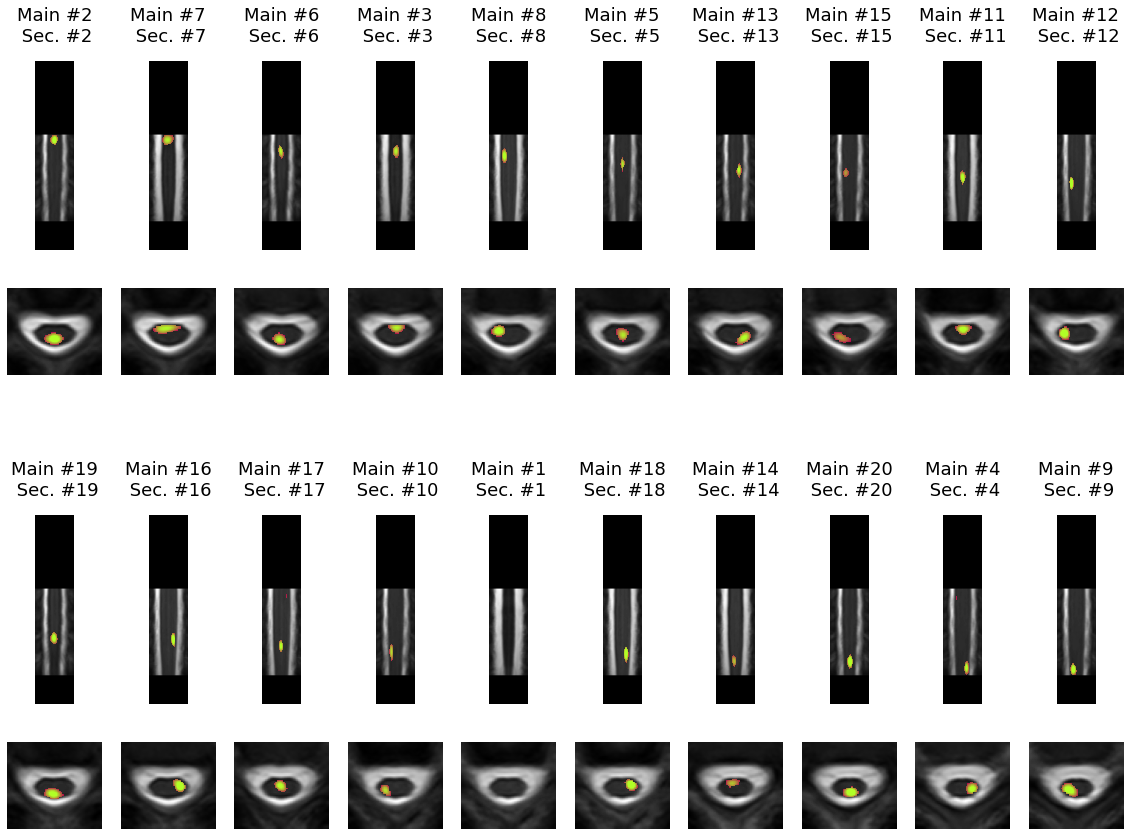

In [15]:
config["templates"]["spinalcord"]="/templates/PAM50/template/T2w_gva_group_mean_resampled.nii.gz"
plotting_gva.sc_plot(show_spinal_levels=False, k_per_line=10, lthresh=2.6, uthresh=5, save_results=False, similarity_method='Dice')

The plotting will be display in flip orientation (Right > left)
COMPUTING SIMILARITY WITH METHOD: Dice
...Compute similarity between pairs of components
...Ordering components based on maximum weight matching
DONE!


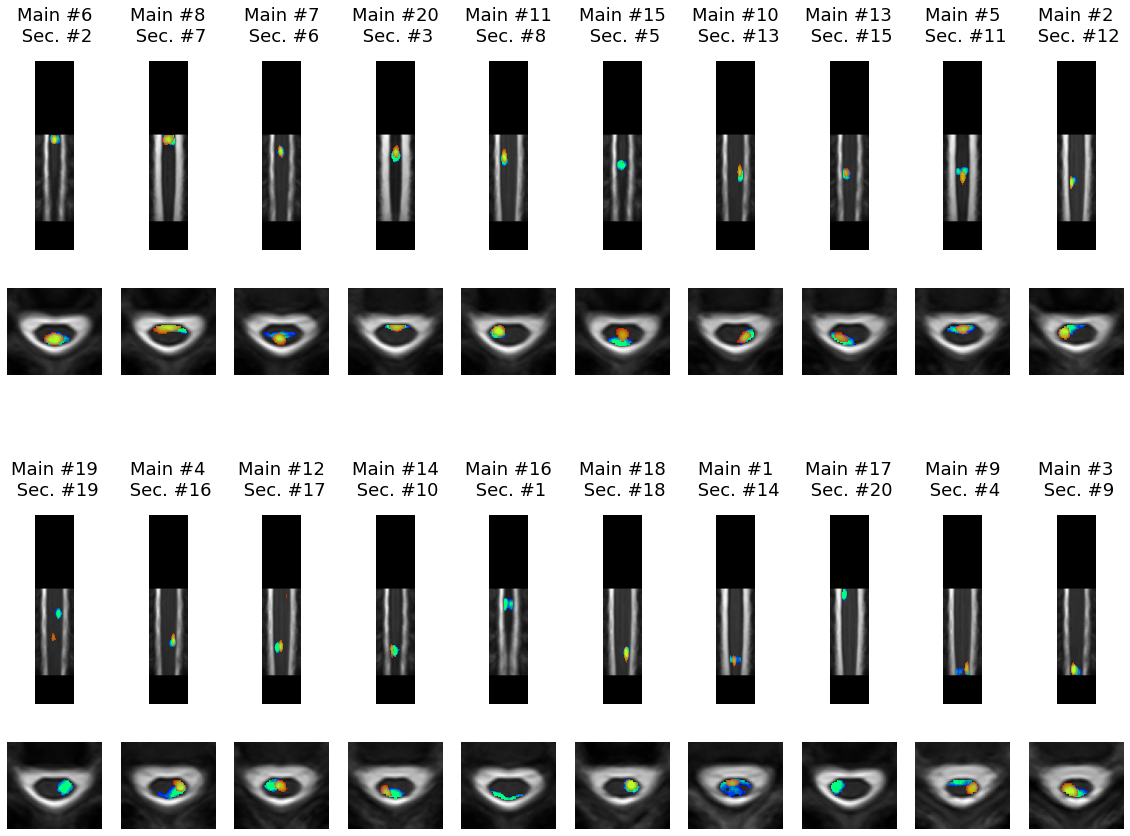

In [7]:
config["templates"]["spinalcord"]="/templates/PAM50/template/T2w_gva_group_mean_resampled.nii.gz"
plotting_gva.sc_plot(show_spinal_levels=False, k_per_line=10, lthresh=2.6, uthresh=5, save_results=False, similarity_method='Dice')

METHOD 1: Comparing two sets of components at specific K values 
gva_ica at K = 20 vs gva_icap at K = 20 

The mean similarity is 0.46


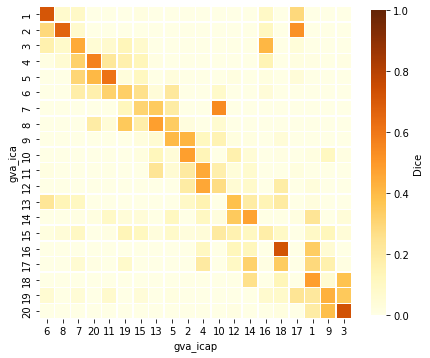

In [52]:
# Similarity has been computed using 'Dice', but 'Cosine' or 'Euclidean distance' could be used instad
params_quant_gva_robustness_1 = {'k_range':range(20,21), 'dataset':'gva', 'analysis':'ica'}
params_quant_gva_robustness_2 = {'k_range':range(20,21), 'dataset':'gva', 'analysis':'icap'}
spine_analysis_mtl = SpineOnlyAnalysis(config,params1=params_quant_gva_robustness_1 ,params2=params_quant_gva_robustness_2)
spine_analysis_mtl.spatial_similarity(k1=20,similarity_method='Dice')

### Analyze spatial similarity

#### Matching is not great for low K, but good otherwise

In [ ]:
# Similarity has been computed using 'Dice', but 'Cosine' or 'Euclidean distance' could be used instad
spine_analysis_gva.spatial_similarity(k1=5,similarity_method='Dice')

In [ ]:
# Similarity has been computed using 'Dice', but 'Cosine' or 'Euclidean distance' could be used instad
spine_analysis_gva.spatial_similarity(k1=10,similarity_method='Dice')

In [ ]:
# Similarity has been computed using 'Dice', but 'Cosine' or 'Euclidean distance' could be used instad
spine_analysis_gva.spatial_similarity(k1=20,similarity_method='Dice')

In [ ]:
spine_analysis_gva.spatial_similarity(k_range=range(4,41),thresh=1.5, similarity_method='Dice', verbose=False)

In [ ]:
spine_analysis_gva.spatial_similarity(k_range=range(4,11),thresh=2, similarity_method='Dice', verbose=False)

### Investigate axial distribution for different Ks

#### Distributions seem a bit different: <font color=red> => TO EXPLORE </font>
- ICA: a lot of LR subdivisions early on
- iCAP: mostly DV </br>

In [ ]:
distribution_gva_ica = spine_analysis_gva.k_axial_distribution(spine_analysis_gva.name1, thresh=2, vox_percentage=70, verbose=False)

In [ ]:
distribution_gva_icap = spine_analysis_gva.k_axial_distribution(spine_analysis_gva.name2, thresh=2, vox_percentage=70, verbose=False)

### `MTL` dataset

### Instantiate class

In [ ]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
params_quant_mtl_1 = {'k_range':range(4,41), 'dataset':'mtl', 'analysis':'ica'}
params_quant_mtl_2 = {'k_range':range(4,41), 'dataset':'mtl', 'analysis':'icap'}

spine_analysis_mtl = SpineOnlyAnalysis(config,params1=params_quant_mtl_1,params2=params_quant_mtl_2)

### Analyze spatial similarity

#### Matching is a bit better for low K, and still good for high K!

In [ ]:
spine_analysis_mtl.spatial_similarity(k1=9,similarity_method='Dice')

In [ ]:
spine_analysis_mtl.spatial_similarity(k1=18,similarity_method='Dice')

In [ ]:
spine_analysis_mtl.spatial_similarity(k1=36,similarity_method='Dice')

In [ ]:
spine_analysis_mtl.spatial_similarity(k_range=range(4,11),thresh=2,similarity_method='Dice', verbose=False)

### Investigate axial distribution for different Ks

#### Distributions seem a bit different: <font color=red> => TO EXPLORE </font>
- ICA: LR subdivisions early on
- iCAP: mostly DV </br>

_Note: here, no Q subdivisions... is it because we have more levels or because of the lower resolution?_

In [ ]:
distribution_mtl_ica = spine_analysis_mtl.k_axial_distribution(spine_analysis_mtl.name1, thresh=2, vox_percentage=70, verbose=False)

In [ ]:
distribution_mtl_icap = spine_analysis_mtl.k_axial_distribution(spine_analysis_mtl.name2, thresh=2, vox_percentage=70, verbose=False)

## Between-dataset comparison

### `ICA` method

### Instantiate class

In [ ]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
params_quant_ica_1 = {'k_range':range(4,41), 'dataset':'gva', 'analysis':'ica'}
params_quant_ica_2 = {'k_range':range(4,41), 'dataset':'mtl', 'analysis':'ica'}

spine_analysis_ica = SpineOnlyAnalysis(config,params1=params_quant_ica_1,params2=params_quant_ica_2)

### Analyze spatial similarity

#### Very bad for low K, good for higher!
Note: here I have chosen $K \times 2$ for `mtl` compared to `gva`, to match the difference in spinal levels that are covered.

In [ ]:
spine_analysis_ica.spatial_similarity(k1=5,k2=9,similarity_method='Dice')

In [ ]:
spine_analysis_ica.spatial_similarity(k1=10,k2=18,similarity_method='Dice')

In [ ]:
spine_analysis_ica.spatial_similarity(k1=20,k2=36,similarity_method='Dice')

### `iCAP` method

### Instantiate class

In [ ]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
params_quant_icap_1 = {'k_range':range(4,41), 'dataset':'gva', 'analysis':'icap'}
params_quant_icap_2 = {'k_range':range(4,41), 'dataset':'mtl', 'analysis':'icap'}

spine_analysis_icap = SpineOnlyAnalysis(config,params1=params_quant_icap_1,params2=params_quant_icap_2)

### Analyze spatial similarity

#### Not great for low K, good for high K

In [ ]:
spine_analysis_icap.spatial_similarity(k1=5,k2=9,similarity_method='Dice')

In [ ]:
spine_analysis_icap.spatial_similarity(k1=20,k2=36,similarity_method='Dice')

# Explore subject-specific maps

### Visualization

In [ ]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis
for dataset in ['mtl', 'gva']:
    for sub in config['list_subjects'][dataset]:
        params_qual_1 = {'k':(9 if dataset == 'mtl' else 5), 'dataset':dataset, 'analysis':'icap', 'subject':'sub-'+sub}
        #params_qual_2 = {'k':(9 if dataset == 'mtl' else 5), 'dataset':dataset, 'analysis':'icap'}

        plotting = Plotting(config,'spinalcord',params1=params_qual_1)
        #plotting = Plotting(config,'spinalcord',params1=params_qual_1,params2=params_qual_2)
        plotting.sc_plot(show_spinal_levels=False, k_per_line=(9 if dataset == 'mtl' else 5), lthresh=1.5, uthresh=3, save_results=True, similarity_method='Dice')
        
        

# Explore durations

### Visualization

In [ ]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis
timings = {}
timings['mtl'] = ['1min','2min','3min','4min','5min','6min']
timings['gva'] = ['1min','2min','3min','4min','5min','6min','9min','12min','15min']

for dataset in ['mtl', 'gva']:
    for dur in timings[dataset]:
        params_qual_1 = {'k':(9 if dataset == 'mtl' else 5), 'dataset':dataset, 'analysis':'icap_duration', 'duration':dur}
        #params_qual_2 = {'k':(9 if dataset == 'mtl' else 5), 'dataset':dataset, 'analysis':'icap'}

        plotting = Plotting(config,'spinalcord',params1=params_qual_1)
        #plotting = Plotting(config,'spinalcord',params1=params_qual_1,params2=params_qual_2)
        plotting.sc_plot(show_spinal_levels=False, k_per_line=(9 if dataset == 'mtl' else 5), lthresh=1.5, uthresh=3, save_results=True, similarity_method='Dice')
        
        

### Assessment of similarity 

#### 'gva' dataset

In [ ]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
dataset="gva"
t_range=[1,2,3,4,5,6,9,12,15]
params_dur_gva_1 = {'k_range':range(5,6),'dataset':dataset, 'analysis':"icap_duration",'t_range':[15]}
params_dur_gva_2 = {'k_range':range(5,6), 'dataset':dataset, 'analysis':"icap_duration", 't_range': t_range}

spine_analysis_duration_gva = SpineOnlyAnalysis(config,params1=params_dur_gva_1,params2=params_dur_gva_2)
spine_analysis_duration_gva.spatial_similarity(k1=5,t_range1=15,t_range2=t_range,similarity_method='Dice',verbose=False)

In [ ]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
dataset="mtl"
t_range=[1,2,3,4,5,6]
params_dur_mtl_1 = {'k_range':range(9,10),'dataset':dataset, 'analysis':"icap_duration",'t_range':[6]}
params_dur_mtl_2 = {'k_range':range(9,10), 'dataset':dataset, 'analysis':"icap_duration", 't_range': t_range}

spine_analysis_duration_mtl = SpineOnlyAnalysis(config,params1=params_dur_mtl_1,params2=params_dur_mtl_2)
spine_analysis_duration_mtl.spatial_similarity(k1=9,t_range1=6,t_range2=t_range,similarity_method='Dice',save_results=True,verbose=False)

# Explore individual maps

In [ ]:
params_indiv_gva = {'k_range':range(5,6),'dataset':'gva', 'analysis':'icap'}
params_indiv_mtl = {'k_range':range(9,10),'dataset':'mtl', 'analysis':'icap'}
spine_analysis_indiv = SpineOnlyAnalysis(config, params1=params_indiv_gva, params2=params_indiv_mtl, load_subjects=True)

In [ ]:
spine_analysis_indiv.subject_distribution(spine_analysis_indiv.name2,k=9,thresh=1.5)